# Introduction and some imports

This notebook was created for educational purposes to study neural networks fine-tuning. [Here](https://www.kaggle.com/datasets/gpiosenka/100-bird-species) is the dataset used for this project.

This notebook was compiled from several versions, since I have trained my models at different devices, and introduced minor changes as well. Therefore output from cells at the beginning may be a little bit different than at the end of notebook.

In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torchvision.io import read_image
from torchvision import transforms
from torchvision.transforms import v2
from PIL import Image

In [2]:
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, classification_report, roc_curve, r2_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils import compute_class_weight
#import umap

In [3]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


# Data loading and cleaning

In [4]:
batch_size = 64
resize_scale = 224, 224

In [5]:
df = pd.read_csv('data/birds.csv')

In [6]:
df.head()

class id                      filepaths           labels data set  \
0       0.0  train/ABBOTTS BABBLER/001.jpg  ABBOTTS BABBLER    train   
1       0.0  train/ABBOTTS BABBLER/007.jpg  ABBOTTS BABBLER    train   
2       0.0  train/ABBOTTS BABBLER/008.jpg  ABBOTTS BABBLER    train   
3       0.0  train/ABBOTTS BABBLER/009.jpg  ABBOTTS BABBLER    train   
4       0.0  train/ABBOTTS BABBLER/002.jpg  ABBOTTS BABBLER    train   

        scientific name  
0  MALACOCINCLA ABBOTTI  
1  MALACOCINCLA ABBOTTI  
2  MALACOCINCLA ABBOTTI  
3  MALACOCINCLA ABBOTTI  
4  MALACOCINCLA ABBOTTI

Some correction is required. There is a mistype in 'PARAKETT  AKULET', and some files have wrong paths for them.

In [7]:
df.query('labels == "PARAKETT  AKULET"')

class id                       filepaths            labels data set  \
59400     373.0  train/PARAKETT  AKULET/038.jpg  PARAKETT  AKULET    train   
59401     373.0  train/PARAKETT  AKULET/079.jpg  PARAKETT  AKULET    train   
59402     373.0  train/PARAKETT  AKULET/137.jpg  PARAKETT  AKULET    train   
59403     373.0  train/PARAKETT  AKULET/128.jpg  PARAKETT  AKULET    train   
59404     373.0  train/PARAKETT  AKULET/005.jpg  PARAKETT  AKULET    train   
...         ...                             ...               ...      ...   
89125     373.0    valid/PARAKETT  AKULET/4.jpg  PARAKETT  AKULET    valid   
89126     373.0    valid/PARAKETT  AKULET/3.jpg  PARAKETT  AKULET    valid   
89127     373.0    valid/PARAKETT  AKULET/5.jpg  PARAKETT  AKULET    valid   
89128     373.0    valid/PARAKETT  AKULET/1.jpg  PARAKETT  AKULET    valid   
89129     373.0    valid/PARAKETT  AKULET/2.jpg  PARAKETT  AKULET    valid   

         scientific name  
59400  AETHIA PSITTACULA  
59401  AETHIA PSITTACULA  
59402  AETHIA PSITTACULA  
59403  AETHIA PSITTACULA  
59404  AETHIA PSITTACULA  
...                  ...  
89125  AETHIA PSITTACULA  
89126  AETHIA PSITTACULA  
89127  AETHIA PSITTACULA  
89128  AETHIA PSITTACULA  
89129  AETHIA PSITTACULA  

[165 rows x 5 columns]

In [8]:
df['labels'] = df['labels'].str.replace('PARAKETT  AKULET', 'PARAKEET AUKLET') # here is the right name
df['filepaths'] = df['filepaths'].str.replace('AKULET', 'AUKLET') # and here is the path to folders

In [9]:
df.loc[df['class id'] == 373]['filepaths']

59400    train/PARAKETT  AUKLET/038.jpg
59401    train/PARAKETT  AUKLET/079.jpg
59402    train/PARAKETT  AUKLET/137.jpg
59403    train/PARAKETT  AUKLET/128.jpg
59404    train/PARAKETT  AUKLET/005.jpg
                      ...              
89125      valid/PARAKETT  AUKLET/4.jpg
89126      valid/PARAKETT  AUKLET/3.jpg
89127      valid/PARAKETT  AUKLET/5.jpg
89128      valid/PARAKETT  AUKLET/1.jpg
89129      valid/PARAKETT  AUKLET/2.jpg
Name: filepaths, Length: 165, dtype: object

In [10]:
df_train = df[['filepaths', 'class id']].loc[df['data set'] == 'train']
df_valid = df[['filepaths', 'class id']].loc[df['data set'] == 'valid']
df_test = df[['filepaths', 'class id']].loc[df['data set'] == 'test']

In [11]:
df_valid['filepaths'] = df_valid['filepaths'].str.replace('PARAKETT  AUKLET', 'PARAKETT AUKLET') # and in the validation part the folder have one space.

In [12]:
df_valid['filepaths'].loc[df_valid['class id'] == 373]

89125    valid/PARAKETT AUKLET/4.jpg
89126    valid/PARAKETT AUKLET/3.jpg
89127    valid/PARAKETT AUKLET/5.jpg
89128    valid/PARAKETT AUKLET/1.jpg
89129    valid/PARAKETT AUKLET/2.jpg
Name: filepaths, dtype: object

In [13]:
df_train['class id'].unique().size, df_train.shape, df_valid.shape, df_test.shape

(525, (84635, 2), (2625, 2), (2625, 2))

Maybe it could be reasonable to create our own test and validation datasets, but for now I'll stick to the author's.

In [14]:
class CustomImageDataset(Dataset):
    def __init__(self, annotations_file, img_dir):
        self.img_labels = annotations_file
        self.img_dir = img_dir

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = Image.open(img_path)
        # image = read_image(img_path)
        label = self.img_labels.iloc[idx, 1]
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Resize(size=resize_scale),
            
            ])
        image = transform(image)
        return image, label

In [15]:
train_dataset = CustomImageDataset(df_train, 'data')
valid_dataset = CustomImageDataset(df_valid, 'data')
test_dataset = CustomImageDataset(df_test, 'data')

In [16]:
train_dataset[0][0].shape

torch.Size([3, 224, 224])

In [17]:
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

The dataset seems to be ready for training!

# Training functions

In [ ]:
def train(dataloader, model, loss_fn, optimizer):
    model.train()
    train_loss = 0
    num_batches = len(dataloader)
    
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.type(torch.LongTensor).to(device)
        pred = model(X)
        loss = loss_fn(pred, y)
        train_loss += loss

        model.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            print(f'Loss is:{loss.item()} [{(batch +1) * len(X)}/{len(dataloader.dataset)}]')
    train_loss = (train_loss / num_batches).item()
    return train_loss

In [20]:
def test(dataloader, model, loss_fn):
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss = 0
    correct = 0
    f1 = 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.type(torch.LongTensor).to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y)
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
            f1 += f1_score(y.cpu(), pred.argmax(1).cpu(), average='weighted')
    test_loss = (test_loss / num_batches).item()
    accuracy = correct / size
    f1 = (f1 / num_batches).item()
    #print(f'Test accuracy: {accuracy * 100}%, average F1 score: {f1} avg loss: {test_loss} \n')
    return accuracy, f1, test_loss

In [ ]:
def train_and_test(train_dataloader, test_dataloader, model, loss_fn, optimizer, n_epochs=1):
    accuracy = []
    test_loss = []
    train_loss = []
    f1 = []
    for t in range(n_epochs):
        print(f'------------Epoch {t + 1}------------')
        train_metrics = train(train_dataloader, model, loss_fn, optimizer)
        train_loss += [train_metrics]
        test_metrics = test(test_dataloader, model, loss_fn)
        accuracy += [test_metrics[0]]
        f1 += [test_metrics[1]]
        test_loss += [test_metrics[2]]
        print(f'Test accuracy: {accuracy[-1] * 100}%, average F1 score: {f1[-1]}, avg loss: {test_loss[-1]} \n')
    print('Done!')
    return accuracy, f1, train_loss, test_loss

# Fine-tuning EfficientNet model for 99% accuracy

<img src='models_comparison.jpg'>

from [arXiv:1905.11946](https://arxiv.org/abs/1905.11946), EfficientNet: Rethinking Model Scaling for Convolutional Neural Networks,
Mingxing Tan, Quoc V. Le, 2019

Authors suggest that their architecture is the most efficient in terms of number of parameters to the accuracy on the ImageNet dataset. The Keras variant of the model is attached to the dataset as well.

I was studying how to train neural networks so learning rate may be not optimal. I tried several strategies for model fine-tuning. The most successfull one presented here:

In [ ]:
from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights
efnet_b0_model = efficientnet_b0(weights=EfficientNet_B0_Weights.DEFAULT)
efnet_b0_model

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 93.6MB/s]


EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [ ]:
# Modify the last layer for 525 classes
efnet_b0_model.classifier[1] = nn.Linear(in_features=1280, out_features=525, bias=True)
efnet_b0_model.to(device)

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

This model has layers intensely trained for image recognition. I am not sure if it will work best for this dataset. However at first I will train the classifier layer to classify outcomes of the convolutionary part of the model.

In [ ]:
# Freeze all layers
for param in efnet_b0_model.parameters():
    param.requires_grad = False

# Unfreeze classifier layer
for param in efnet_b0_model.classifier.parameters():
    param.requires_grad = True

I liked the RMSprop optimizer at most during previous trainings, so I'll use it now

Some tests before training

In [ ]:
x = train_dataset[0][0]
x.shape

torch.Size([3, 224, 224])

In [ ]:
efnet_b0_model(x.unsqueeze(0).to(device)).shape

torch.Size([1, 525])

In [ ]:
loss_fn = nn.CrossEntropyLoss()
test(valid_dataloader, efnet_b0_model, loss_fn)

/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

(0.002285714285714286, 0.0010938063672438674, 6.2974162101745605)

In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.RMSprop(efnet_b0_model.parameters(), lr=1e-2)
accuracy_efnet, f1_efnet, train_loss_efnet, test_loss_efnet  = train_and_test(
    train_dataloader=train_dataloader,
    test_dataloader=valid_dataloader,
    model=efnet_b0_model,
    loss_fn=loss_fn,
    optimizer=optimizer,
    n_epochs=3)

------------Epoch 1------------
Loss is:6.283459663391113 [64/84635]


/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Loss is:2.6397616863250732 [6464/84635]
Loss is:3.475092649459839 [12864/84635]
Loss is:1.7397862672805786 [19264/84635]
Loss is:1.811912178993225 [25664/84635]
Loss is:1.9569593667984009 [32064/84635]
Loss is:1.844955563545227 [38464/84635]
Loss is:2.02113676071167 [44864/84635]
Loss is:1.321803331375122 [51264/84635]
Loss is:1.3588827848434448 [57664/84635]
Loss is:1.5011444091796875 [64064/84635]
Loss is:2.875591993331909 [70464/84635]
Loss is:2.5834341049194336 [76864/84635]
Loss is:1.6223094463348389 [83264/84635]


/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

Test accuracy: 83.6952380952381%, average F1 score: 0.839409722222222, avg loss: 0.9281741976737976 

------------Epoch 2------------
Loss is:1.0176856517791748 [64/84635]


/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Loss is:0.7232869267463684 [6464/84635]
Loss is:1.2255945205688477 [12864/84635]
Loss is:0.7628892660140991 [19264/84635]
Loss is:1.0508592128753662 [25664/84635]
Loss is:0.8466914892196655 [32064/84635]
Loss is:1.6946159601211548 [38464/84635]
Loss is:1.3481717109680176 [44864/84635]
Loss is:1.5302542448043823 [51264/84635]
Loss is:0.8843624591827393 [57664/84635]
Loss is:1.2277429103851318 [64064/84635]
Loss is:1.2041387557983398 [70464/84635]
Loss is:1.4461044073104858 [76864/84635]
Loss is:2.061635732650757 [83264/84635]


/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

Test accuracy: 84.83809523809524%, average F1 score: 0.8496527777777778, avg loss: 1.0020191669464111 

------------Epoch 3------------
Loss is:1.2199666500091553 [64/84635]


/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Loss is:1.0837516784667969 [6464/84635]
Loss is:0.6454070210456848 [12864/84635]
Loss is:1.206797480583191 [19264/84635]
Loss is:1.5318012237548828 [25664/84635]
Loss is:0.9375451803207397 [32064/84635]
Loss is:1.1039502620697021 [38464/84635]
Loss is:1.298596739768982 [44864/84635]
Loss is:0.8241966962814331 [51264/84635]
Loss is:1.297478199005127 [57664/84635]
Loss is:1.3439149856567383 [64064/84635]
Loss is:2.138524293899536 [70464/84635]
Loss is:1.7273623943328857 [76864/84635]
Loss is:1.8508433103561401 [83264/84635]


/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

Test accuracy: 85.94285714285715%, average F1 score: 0.8615079365079366, avg loss: 1.0038762092590332 

Done!


In [ ]:
for param_group in optimizer.param_groups:
    param_group['lr'] = 1e-3
tup = train_and_test(
    train_dataloader=train_dataloader,
    test_dataloader=valid_dataloader,
    model=efnet_b0_model,
    loss_fn=loss_fn,
    optimizer=optimizer,
    n_epochs=3)
accuracy_efnet += tup[0]
f1_efnet += tup[1]
train_loss_efnet += tup[2]
test_loss_efnet += tup[3]

------------Epoch 1------------
Loss is:0.932492196559906 [64/84635]


/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Loss is:1.117256760597229 [6464/84635]
Loss is:0.6119979619979858 [12864/84635]
Loss is:0.8748358488082886 [19264/84635]
Loss is:1.07264244556427 [25664/84635]
Loss is:1.211572289466858 [32064/84635]
Loss is:0.6742678284645081 [38464/84635]
Loss is:0.4134420156478882 [44864/84635]
Loss is:0.2886078953742981 [51264/84635]
Loss is:0.5312103629112244 [57664/84635]
Loss is:0.6834883093833923 [64064/84635]
Loss is:0.5375209450721741 [70464/84635]
Loss is:1.328307867050171 [76864/84635]
Loss is:0.5305395722389221 [83264/84635]


/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

Test accuracy: 88.41904761904762%, average F1 score: 0.8873015873015875, avg loss: 0.7813106179237366 

------------Epoch 2------------
Loss is:1.309808373451233 [64/84635]


/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Loss is:0.7963529825210571 [6464/84635]
Loss is:1.020511507987976 [12864/84635]
Loss is:0.4572000801563263 [19264/84635]
Loss is:0.5253131985664368 [25664/84635]
Loss is:0.31827518343925476 [32064/84635]
Loss is:0.809120774269104 [38464/84635]
Loss is:0.13192477822303772 [44864/84635]
Loss is:0.222194641828537 [51264/84635]
Loss is:0.3715026080608368 [57664/84635]
Loss is:0.47806552052497864 [64064/84635]
Loss is:0.20837651193141937 [70464/84635]
Loss is:1.0382916927337646 [76864/84635]
Loss is:0.3501216173171997 [83264/84635]


/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

Test accuracy: 89.29523809523809%, average F1 score: 0.8952132936507935, avg loss: 0.689660370349884 

------------Epoch 3------------
Loss is:0.47606152296066284 [64/84635]


/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Loss is:0.41293513774871826 [6464/84635]
Loss is:0.463680237531662 [12864/84635]
Loss is:0.5643265843391418 [19264/84635]
Loss is:0.22631704807281494 [25664/84635]
Loss is:0.5479084849357605 [32064/84635]
Loss is:0.3936327397823334 [38464/84635]
Loss is:0.5490835905075073 [44864/84635]
Loss is:0.31135544180870056 [51264/84635]
Loss is:0.6336285471916199 [57664/84635]
Loss is:0.32505902647972107 [64064/84635]
Loss is:0.27810925245285034 [70464/84635]
Loss is:0.49601617455482483 [76864/84635]
Loss is:0.8424925208091736 [83264/84635]


/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

Test accuracy: 89.71428571428571%, average F1 score: 0.8988839285714283, avg loss: 0.677086591720581 

Done!


In [ ]:
for param_group in optimizer.param_groups:
    param_group['lr'] = 1e-2
tup = train_and_test(
    train_dataloader=train_dataloader,
    test_dataloader=valid_dataloader,
    model=efnet_b0_model,
    loss_fn=loss_fn,
    optimizer=optimizer,
    n_epochs=3)
accuracy_efnet += tup[0]
f1_efnet += tup[1]
train_loss_efnet += tup[2]
test_loss_efnet += tup[3]

------------Epoch 1------------
Loss is:1.147242546081543 [64/84635]


/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Loss is:0.28459444642066956 [6464/84635]
Loss is:0.3262282907962799 [12864/84635]
Loss is:1.103971004486084 [19264/84635]
Loss is:0.37528327107429504 [25664/84635]
Loss is:1.3877562284469604 [32064/84635]
Loss is:1.2785588502883911 [38464/84635]
Loss is:0.8860640525817871 [44864/84635]
Loss is:1.333117961883545 [51264/84635]
Loss is:0.9989997148513794 [57664/84635]
Loss is:2.1298410892486572 [64064/84635]
Loss is:1.881631851196289 [70464/84635]
Loss is:1.0820895433425903 [76864/84635]
Loss is:1.1716305017471313 [83264/84635]


/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

Test accuracy: 85.67619047619047%, average F1 score: 0.859375, avg loss: 1.032647967338562 

------------Epoch 2------------
Loss is:0.6743975877761841 [64/84635]


/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Loss is:0.9112101793289185 [6464/84635]
Loss is:0.6304181218147278 [12864/84635]
Loss is:0.6190299391746521 [19264/84635]
Loss is:0.5137761831283569 [25664/84635]
Loss is:1.3906822204589844 [32064/84635]
Loss is:0.6189852356910706 [38464/84635]
Loss is:1.602389931678772 [44864/84635]
Loss is:0.8503133654594421 [51264/84635]
Loss is:0.9401400089263916 [57664/84635]
Loss is:0.9742262363433838 [64064/84635]
Loss is:0.49060744047164917 [70464/84635]
Loss is:1.2815215587615967 [76864/84635]
Loss is:1.0883822441101074 [83264/84635]


/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

Test accuracy: 87.2%, average F1 score: 0.8732266865079364, avg loss: 1.1141011714935303 

------------Epoch 3------------


/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Loss is:0.7277175188064575 [64/84635]
Loss is:1.3563348054885864 [6464/84635]
Loss is:0.8119021654129028 [12864/84635]
Loss is:0.49996045231819153 [19264/84635]
Loss is:0.9355930089950562 [25664/84635]
Loss is:1.1566810607910156 [32064/84635]
Loss is:0.48199567198753357 [38464/84635]
Loss is:1.3698052167892456 [44864/84635]
Loss is:0.897639274597168 [51264/84635]
Loss is:0.9075608253479004 [57664/84635]
Loss is:0.3921763598918915 [64064/84635]
Loss is:0.5333089232444763 [70464/84635]
Loss is:0.7846385836601257 [76864/84635]
Loss is:2.134559392929077 [83264/84635]


/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

Test accuracy: 87.58095238095238%, average F1 score: 0.878486394557823, avg loss: 1.1442197561264038 

Done!


In [ ]:
for param_group in optimizer.param_groups:
    param_group['lr'] = 1e-3
tup = train_and_test(
    train_dataloader=train_dataloader,
    test_dataloader=valid_dataloader,
    model=efnet_b0_model,
    loss_fn=loss_fn,
    optimizer=optimizer,
    n_epochs=3)
accuracy_efnet += tup[0]
f1_efnet += tup[1]
train_loss_efnet += tup[2]
test_loss_efnet += tup[3]

------------Epoch 1------------
Loss is:0.14400719106197357 [64/84635]


/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Loss is:0.796532154083252 [6464/84635]
Loss is:0.6118199825286865 [12864/84635]
Loss is:0.518120288848877 [19264/84635]
Loss is:0.874075710773468 [25664/84635]
Loss is:0.4464111328125 [32064/84635]
Loss is:0.1833028495311737 [38464/84635]
Loss is:0.5270000696182251 [44864/84635]
Loss is:0.31908461451530457 [51264/84635]
Loss is:0.6874914169311523 [57664/84635]
Loss is:0.328037291765213 [64064/84635]
Loss is:0.32279345393180847 [70464/84635]
Loss is:0.6911312937736511 [76864/84635]
Loss is:0.8435264825820923 [83264/84635]


/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

Test accuracy: 89.25714285714285%, average F1 score: 0.8720486111111112, avg loss: 1.3806289434432983 

------------Epoch 2------------
Loss is:0.434024840593338 [64/84635]


/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Loss is:0.36141711473464966 [6464/84635]
Loss is:0.7609803080558777 [12864/84635]
Loss is:0.5447317361831665 [19264/84635]
Loss is:0.15341824293136597 [25664/84635]
Loss is:0.6016111969947815 [32064/84635]
Loss is:0.5685275793075562 [38464/84635]
Loss is:0.23910294473171234 [44864/84635]
Loss is:0.5082677006721497 [51264/84635]
Loss is:0.45715439319610596 [57664/84635]
Loss is:0.2851269543170929 [64064/84635]
Loss is:0.21943137049674988 [70464/84635]
Loss is:0.5069125890731812 [76864/84635]
Loss is:0.5892732739448547 [83264/84635]


/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

Test accuracy: 89.52380952380953%, average F1 score: 0.8970486111111112, avg loss: 0.9063581824302673 

------------Epoch 3------------
Loss is:0.510293185710907 [64/84635]


/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Loss is:0.5975821614265442 [6464/84635]
Loss is:0.8721694350242615 [12864/84635]
Loss is:0.5774880647659302 [19264/84635]
Loss is:1.0209825038909912 [25664/84635]
Loss is:0.55396568775177 [32064/84635]
Loss is:0.5183253884315491 [38464/84635]
Loss is:0.20072439312934875 [44864/84635]
Loss is:0.14641892910003662 [51264/84635]
Loss is:0.5282192230224609 [57664/84635]
Loss is:0.1739538311958313 [64064/84635]
Loss is:0.41570672392845154 [70464/84635]
Loss is:0.1888849139213562 [76864/84635]
Loss is:0.3157477080821991 [83264/84635]


/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

Test accuracy: 89.86666666666666%, average F1 score: 0.9000992063492064, avg loss: 0.9113365411758423 

Done!


In [ ]:
torch.save(efnet_b0_model, '/kaggle/working/EfficientNetB0.pth')

In [ ]:
t = test(test_dataloader, efnet_b0_model, loss_fn)
print(f'Test accuracy: {t[0]}, F1 score: {t[1]}, loss: {t[2]}')

/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

Test accuracy: 0.9097142857142857, F1 score: 0.9092261904761904, loss: 0.6630667448043823


Text(0.5, 1.0, 'Validation performance of EfficientNetB0 model')

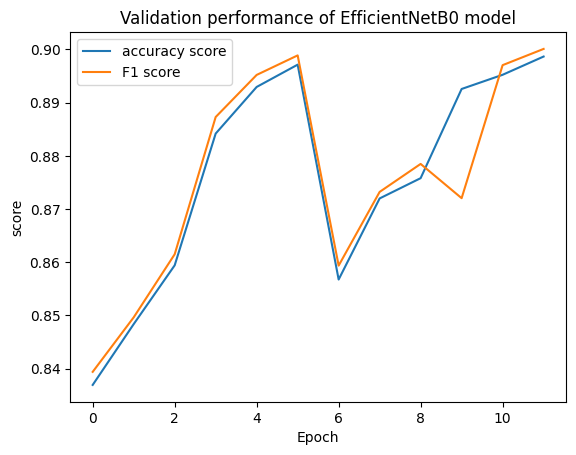

In [ ]:
plt.plot(accuracy_efnet, label='accuracy score')
plt.plot(f1_efnet, label='F1 score')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('score')
plt.title('Validation performance of EfficientNetB0 model');

Text(0.5, 1.0, 'train and validation loss of EfficientNetB0 model')

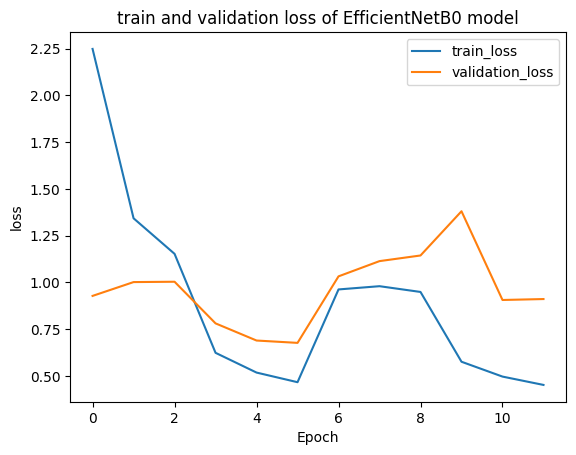

In [ ]:
plt.plot(train_loss_efnet, label='train_loss')
plt.plot(test_loss_efnet, label='validation_loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('loss')
plt.title('train and validation loss of EfficientNetB0 model')

It may seem it would be beneficial to decrease learning rate, rather than increasing it. However it brought no significant increase in accuracy (data not shown in this notebook). Or maybe I could have stopped after 6th epoch and it would be enough. However, I got a model with 90% accuracy. (I renamed the file and uploaded it to Kaggle input, the accuracy is exactly the same)

In [22]:
model = torch.load('EfficientNetB0_fine_tuned.pth').to(device)

In [ ]:
loss_fn = nn.CrossEntropyLoss()
t = test(test_dataloader, model, loss_fn)
print(f'Test accuracy: {t[0]}, F1 score: {t[1]}, loss: {t[2]}')

Test accuracy: 0.9097142857142857, F1 score: 0.9112103174603177, loss: 0.6626487374305725


The convolutionary layers were pretrained for different types of objects. It seems that training of classifier layer alone is not very beneficial. So I decided to unfreeze parameters of the whole model and train it with gradually decreasing learning rate.

In [ ]:
for param in model.parameters():
    param.requires_grad = True

In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.RMSprop(model.parameters(), lr=1e-3)
accuracy_efnet, f1_efnet, train_loss_efnet, test_loss_efnet  = train_and_test(
    train_dataloader=train_dataloader,
    test_dataloader=valid_dataloader,
    model=model,
    loss_fn=loss_fn,
    optimizer=optimizer,
    n_epochs=3)

------------Epoch 1------------
Loss is:0.6990286111831665 [64/84635]
Loss is:1.2471421957015991 [6464/84635]
Loss is:1.3373076915740967 [12864/84635]
Loss is:1.261409044265747 [19264/84635]
Loss is:1.0348411798477173 [25664/84635]
Loss is:0.5046025514602661 [32064/84635]
Loss is:0.772251546382904 [38464/84635]
Loss is:0.5986621379852295 [44864/84635]
Loss is:0.7491096258163452 [51264/84635]
Loss is:0.6738120317459106 [57664/84635]
Loss is:0.7099061608314514 [64064/84635]
Loss is:0.6264574527740479 [70464/84635]
Loss is:0.5330855846405029 [76864/84635]
Loss is:0.8895760774612427 [83264/84635]
Test accuracy: 91.35238095238095%, average F1 score: 0.9146329365079365, avg loss: 0.32600095868110657 

------------Epoch 2------------
Loss is:0.4153432250022888 [64/84635]
Loss is:0.28913456201553345 [6464/84635]
Loss is:0.27244409918785095 [12864/84635]
Loss is:0.31390947103500366 [19264/84635]
Loss is:0.4558669328689575 [25664/84635]
Loss is:0.46640416979789734 [32064/84635]
Loss is:0.6504033

In [ ]:
loss_fn = nn.CrossEntropyLoss()
t = test(test_dataloader, model, loss_fn)
print(f'Test accuracy: {t[0]}, F1 score: {t[1]}, loss: {t[2]}')

Test accuracy: 0.9344761904761905, F1 score: 0.9350198412698413, loss: 0.212987020611763


In [ ]:
torch.save(model, '/kaggle/working/EfficientNetB0.pth')

In [ ]:
for param_group in optimizer.param_groups:
    param_group['lr'] = 1e-4
tup = train_and_test(
    train_dataloader=train_dataloader,
    test_dataloader=valid_dataloader,
    model=model,
    loss_fn=loss_fn,
    optimizer=optimizer,
    n_epochs=3)
accuracy_efnet += tup[0]
f1_efnet += tup[1]
train_loss_efnet += tup[2]
test_loss_efnet += tup[3]

------------Epoch 1------------
Loss is:0.26586899161338806 [64/84635]
Loss is:0.13590839505195618 [6464/84635]
Loss is:0.2339959442615509 [12864/84635]
Loss is:0.08922451734542847 [19264/84635]
Loss is:0.07399803400039673 [25664/84635]
Loss is:0.03249410167336464 [32064/84635]
Loss is:0.016997575759887695 [38464/84635]
Loss is:0.12539605796337128 [44864/84635]
Loss is:0.054346513003110886 [51264/84635]
Loss is:0.04365769773721695 [57664/84635]
Loss is:0.021443651989102364 [64064/84635]
Loss is:0.007852601818740368 [70464/84635]
Loss is:0.014560895971953869 [76864/84635]
Loss is:0.013754626736044884 [83264/84635]
Test accuracy: 97.37142857142858%, average F1 score: 0.9749503968253967, avg loss: 0.10837604105472565 

------------Epoch 2------------
Loss is:0.025472547858953476 [64/84635]
Loss is:0.10686469078063965 [6464/84635]
Loss is:0.0021549940574914217 [12864/84635]
Loss is:0.03000042773783207 [19264/84635]
Loss is:0.027016308158636093 [25664/84635]
Loss is:0.005824587307870388 [32

In [220]:
loss_fn = nn.CrossEntropyLoss()
t = test(test_dataloader, model, loss_fn)
print(f'Test accuracy: {t[0]}, F1 score: {t[1]}, loss: {t[2]}')

Test accuracy: 0.9912380952380953, F1 score: 0.9911706349206348, loss: 0.0293864868581295


Acquiring the model with accuracy of 99% for the test dataset I decided to stop training it for the purposes of this project.

In [ ]:
torch.save(model, '/kaggle/working/EfficientNetB0.pth')

Text(0.5, 1.0, 'Validation performance of EfficientNetB0 model')

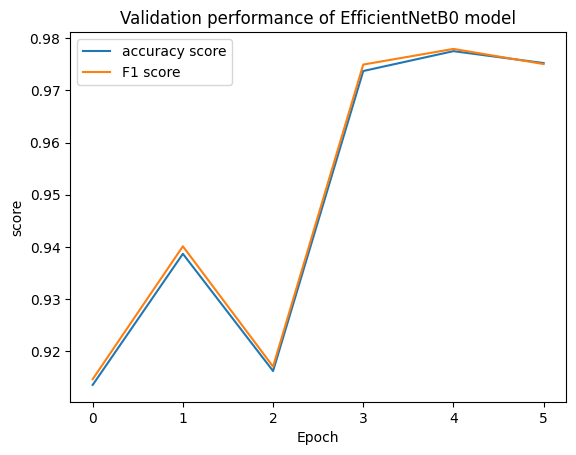

In [ ]:
plt.plot(accuracy_efnet, label='accuracy score')
plt.plot(f1_efnet, label='F1 score')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('score')
plt.title('Validation performance of EfficientNetB0 model')

Text(0.5, 1.0, 'train and validation loss of EfficientNetB0 model')

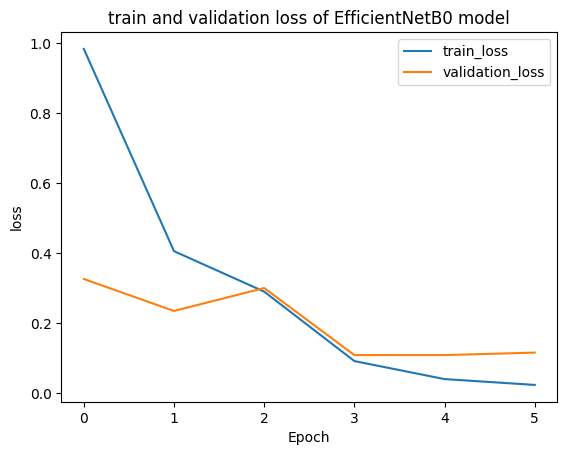

In [ ]:
plt.plot(train_loss_efnet, label='train_loss')
plt.plot(test_loss_efnet, label='validation_loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('loss')
plt.title('train and validation loss of EfficientNetB0 model')

In [32]:
model = torch.load('EfficientNetB0_99%.pth').to(device)

In [221]:
loss_fn = nn.CrossEntropyLoss()
t = test(test_dataloader, model, loss_fn)
print(f'Test accuracy: {t[0]}, F1 score: {t[1]}, loss: {t[2]}')

Test accuracy: 0.9912380952380953, F1 score: 0.9915674603174603, loss: 0.0293864868581295


In [27]:
n = len(test_dataset)
y_true = np.empty(n)
y_pred = np.empty(n)
for i, (X, y) in enumerate(test_dataset):
    X = X.unsqueeze(0).to(device)
    pred = model(X).argmax()
    y_pred[i] = pred.cpu().detach().numpy()
    y_true[i] = y

In [28]:
labels = df[['class id', 'labels', 'scientific name']].groupby('class id').agg(lambda x: ', '.join(x.unique()))
labels.columns = ['labels', 'scientific name']

In [29]:
y_true.shape[0], (y_true != y_pred).sum()

(2625, 23)

Among 2625 images we have 23 mistakes. The table below shows which birds were confused.

In [30]:
wrong = df.loc[df['data set'] == 'test'].loc[y_true != y_pred]
wrong['predicted'] = y_pred[y_true != y_pred]
wrong_labels = labels['labels'].iloc[wrong['predicted']].reset_index()
wrong = pd.merge(wrong, wrong_labels, left_on='predicted', right_on='class id').drop(columns='class id_y')
wrong = wrong.drop_duplicates()
wrong

class id_x                                 filepaths  \
0         23.0                test/AMERICAN WIGEON/3.jpg   
1         29.0                       test/ANIANIAU/4.jpg   
2         43.0              test/AUSTRAL CANASTERO/4.jpg   
3         78.0             test/BLACK NECKED STILT/3.jpg   
4         79.0                  test/BLACK SKIMMER/1.jpg   
5         94.0                    test/BLUE DACNIS/4.jpg   
6         95.0          test/BLUE GRAY GNATCATCHER/3.jpg   
7         96.0                  test/BLUE GROSBEAK/5.jpg   
8        111.0                     test/BUFFLEHEAD/4.jpg   
10       384.0                      test/PUNA TEAL/2.jpg   
12       252.0                    test/GREAT POTOO/5.jpg   
13       270.0                       test/HAMERKOP/4.jpg   
14       299.0                test/INLAND DOTTEREL/4.jpg   
15       324.0              test/LOGGERHEAD SHRIKE/5.jpg   
16       340.0                 test/MCKAYS BUNTING/5.jpg   
17       348.0  test/NORTHERN BEARDLESS TYRANNULET/1.jpg   
18       361.0         test/ORANGE BREASTED TROGON/1.jpg   
19       432.0                    test/SAYS PHOEBE/2.jpg   
20       456.0              test/STRIATED CARACARA/5.jpg   
21       469.0                      test/TEAL DUCK/4.jpg   
22       474.0           test/TRICOLORED BLACKBIRD/5.jpg   
24       474.0           test/TRICOLORED BLACKBIRD/3.jpg   
26       505.0               test/WILLOW PTARMIGAN/4.jpg   

                         labels_x data set            scientific name  \
0                 AMERICAN WIGEON     test           MARECA AMERICANA   
1                        ANIANIAU     test              MAGUMMA PARVA   
2               AUSTRAL CANASTERO     test         ASTHENES ANTHOIDES   
3              BLACK NECKED STILT     test       HIMANTOPUS MEXICANUS   
4                   BLACK SKIMMER     test             RYNCHOPS NIGER   
5                     BLUE DACNIS     test              DACNIS CAYANA   
6           BLUE GRAY GNATCATCHER     test        POLIOPTILA CAERULEA   
7                   BLUE GROSBEAK     test         PASSERINA CAERULEA   
8                      BUFFLEHEAD     test          BUCEPHALA ALBEOLA   
10                      PUNA TEAL     test                  ANAS PUNA   
12                    GREAT POTOO     test          NYCTIBIUS GRANDIS   
13                       HAMERKOP     test            SCOPUS UMBRETTA   
14                INLAND DOTTEREL     test       CHARADRIUS AUSTRALIS   
15              LOGGERHEAD SHRIKE     test        LANIUS LUDOVICIANUS   
16                 MCKAYS BUNTING     test  PLECTROPHENAX HYPERBOREUS   
17  NORTHERN BEARDLESS TYRANNULET     test        CAMPTOSTOMA IMBERBE   
18         ORANGE BREASTED TROGON     test         HARPACTES ORESKIOS   
19                    SAYS PHOEBE     test              SAYORNIS SAYA   
20              STRIATED CARACARA     test     PHALCOBOENUS AUSTRALIS   
21                      TEAL DUCK     test                ANAS CRECCA   
22           TRICOLORED BLACKBIRD     test          AGELAIUS TRICOLOR   
24           TRICOLORED BLACKBIRD     test          AGELAIUS TRICOLOR   
26               WILLOW PTARMIGAN     test            LAGOPUS LAGOPUS   

    predicted                 labels_y  
0       451.0   SPOTTED WHISTLING DUCK  
1       370.0                   PALILA  
2        46.0         AZARAS SPINETAIL  
3        60.0             BANDED STILT  
4        98.0               BLUE HERON  
5       404.0  RED LEGGED HONEYCREEPER  
6       192.0              DUSKY ROBIN  
7       135.0          CHARA DE COLLAR  
8       358.0        NORTHERN SHOVELER  
10      358.0        NORTHERN SHOVELER  
12      158.0          COMMON POORWILL  
13      523.0   GREY HEADED CHACHALACA  
14      449.0    SPOON BILED SANDPIPER  
15      262.0        GREY CUCKOOSHRIKE  
16      440.0          SMITHS LONGSPUR  
17      255.0            GREATER PEWEE  
18      405.0         RED NAPED TROGON  
19       45.0                 AVADAVAT  
20      462.0              SURF

# The real duck-test

"If it looks like a duck, swims like a duck, and quacks like a duck, then it probably is a duck."

Now it's time to test our model for some images taken in nature recently. These images are surely not presented in the dataset used for this project. Some random images from the internet are presented as well.

In [31]:
transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Resize(size=resize_scale),
            ])

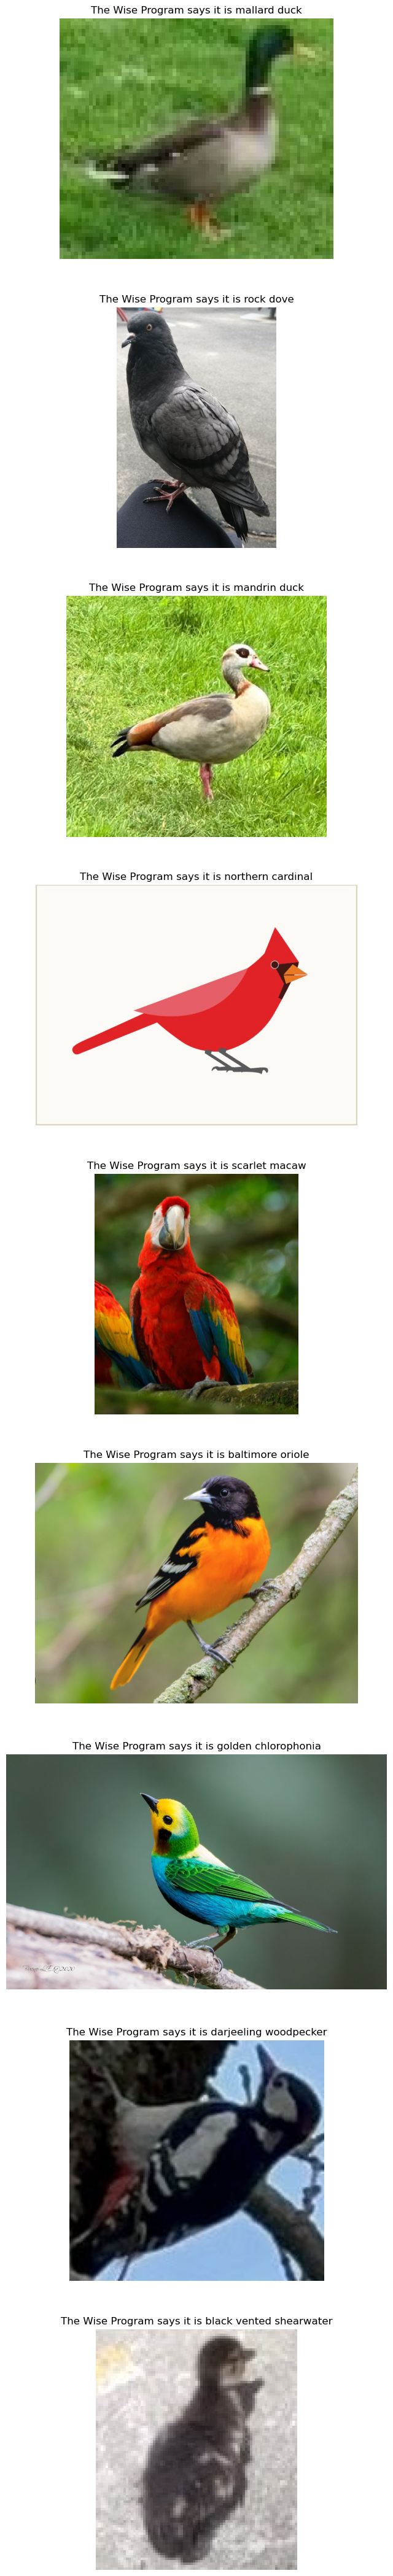

In [34]:

for dirname, _, filenames in os.walk('data/duck_test'):
    n_images = len(filenames)
    axes = plt.subplots(figsize=(8,n_images * 6), nrows=n_images)[1]

    for i, filename in enumerate(filenames):
        img_path = os.path.join(dirname, filename)
        image = Image.open(img_path)
        axes[i].imshow(image)
        axes[i].axis('off')
        image_tensor = transform(image)
        pred = model(image_tensor.unsqueeze(0).to(device))
        predicted = labels['labels'].iloc[pred.argmax().item()].lower()
        axes[i].set_title(f'The Wise Program says it is {predicted}')

At first it wass obvious for me that this model fails the real duck test. Here are my thoughts on reasons for that:

* our model is trained for images of good quality, without any distortions or rotations. It may be wise to implement those things to the data-loaders.
* Variety of poses of birds on images in this dataset may be far inferior, if compared to the real-world birds. Maybe this could be overcome by hiding random parts of images, so the neural network will have to find the species features in different parts of a bird's body.
* "One significant shortcoming in the data set is the ratio of male species images to female species images. About 80% of the images are of the male and 20% of the female. Males typical are far more diversely colored while the females of a species are typically bland. Consequently male and female images may look entirely different." From the description of the dataset. Whether on a real photo a wild duck may be female with very high probability, and we realize that it is somewhat different from a male.
* It does not seem probable that a model will identify juvenile birds if it was trained exclusively for photos of adult ones. However it is always fun to see what it will predict, which is why there is a duckling photo.

However later I realized that most common birds in my area are not presented in the dataset. So here 3 first images were taken outdoors by me and my colleagues. Egyptian goose was called a mandarin duck by mistake. Next 3 images were randomly chosen from internet. The model does fine with these. 3 of the latter images represent a birds which are not presented in the dataset, so the model is unable to predict them correctly.

# Implementation of image augmentation to the dataset

To increase performance on real photos I decided to implement transformation techniques to the dataset, and train the model again. To speed up the training process I decreased images resolution and added transformations to the dataset class.

In [22]:
batch_size = 64
resize_scale = 112, 112 # it should increase training speed a little bit

In [25]:
class CustomImageDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=True, resize_scale=resize_scale):
        self.img_labels = annotations_file
        self.img_dir = img_dir
        self.transform = transform
        self.resize_scale = resize_scale

    def __len__(self):
        return len(self.img_labels)
    
    def load_image(self, idx): # function to get image not transformed to tensor, nor normalized
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = Image.open(img_path)
        return image

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = read_image(img_path).to(device)
        label = self.img_labels.iloc[idx, 1]
        if self.transform:
            transforms = v2.Compose([
                            v2.RandomResizedCrop(size=self.resize_scale, scale=(0.5, 1), antialias=True), # we crop random part of the image
                            v2.RandomHorizontalFlip(p=0.5), # flip half of images
                            v2.ToDtype(torch.float32, scale=True),
                            v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) # those are mean and std from imagenet dataset. Those were used to train a model as stated in docs
                            ])
        else:
            transforms = v2.Compose([
                            v2.Resize(size=self.resize_scale),
                            v2.ToDtype(torch.float32, scale=True),
                            v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) # those are mean and std from imagenet dataset. Those were used to train a model as stated in docs
                            ])
        out = transforms(image)
        return out, label

In [26]:
train_dataset = CustomImageDataset(df_train, 'data')
valid_dataset = CustomImageDataset(df_valid, 'data')
test_dataset = CustomImageDataset(df_test, 'data')
test_dataset_no_transform = CustomImageDataset(df_test, 'data', transform=False)
test_dataset_no_transform_large = CustomImageDataset(df_test, 'data', transform=False, resize_scale=(224, 224))

In [27]:
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)
test_dataloader_no_transform = DataLoader(test_dataset_no_transform, batch_size=batch_size, shuffle=True)
test_dataloader_no_transform_large = DataLoader(test_dataset_no_transform_large, batch_size=batch_size, shuffle=True)

# Training a new model for transformed images

In [ ]:
from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights
efnet_b0_model = efficientnet_b0(weights=EfficientNet_B0_Weights.DEFAULT)
efnet_b0_model

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 88.9MB/s]


EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [ ]:
# Freeze all layers
for param in efnet_b0_model.parameters():
    param.requires_grad = False

In [ ]:
# Modify the last layer for 525 classes
efnet_b0_model.classifier[1] = nn.Linear(in_features=1280, out_features=525, bias=True)
efnet_b0_model.to(device)

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.RMSprop(efnet_b0_model.parameters(), lr=1e-2)
accuracy_efnet, f1_efnet, train_loss_efnet, test_loss_efnet  = train_and_test(
    train_dataloader=train_dataloader,
    test_dataloader=valid_dataloader,
    model=efnet_b0_model,
    loss_fn=loss_fn,
    optimizer=optimizer,
    n_epochs=3)

------------Epoch 1------------
Loss is:6.314594268798828 [64/84635]
Loss is:6.119238376617432 [6464/84635]
Loss is:6.437923908233643 [12864/84635]
Loss is:5.811657428741455 [19264/84635]
Loss is:5.155664920806885 [25664/84635]
Loss is:5.173427104949951 [32064/84635]
Loss is:5.419734954833984 [38464/84635]
Loss is:5.7462568283081055 [44864/84635]
Loss is:5.252162933349609 [51264/84635]
Loss is:4.077329158782959 [57664/84635]
Loss is:5.611083984375 [64064/84635]
Loss is:5.273382663726807 [70464/84635]
Loss is:5.159102916717529 [76864/84635]
Loss is:5.559659004211426 [83264/84635]
Test accuracy: 52.91428571428571%, average F1 score: 0.5380332341269841, avg loss: 3.3279104232788086 

------------Epoch 2------------
Loss is:4.016843318939209 [64/84635]
Loss is:3.9517226219177246 [6464/84635]
Loss is:4.750829696655273 [12864/84635]
Loss is:5.025219440460205 [19264/84635]
Loss is:4.666477203369141 [25664/84635]
Loss is:6.491703510284424 [32064/84635]
Loss is:5.646913528442383 [38464/84635]
L

In [ ]:
for param_group in optimizer.param_groups:
    param_group['lr'] = 1e-3
tup = train_and_test(
    train_dataloader=train_dataloader,
    test_dataloader=valid_dataloader,
    model=efnet_b0_model,
    loss_fn=loss_fn,
    optimizer=optimizer,
    n_epochs=3)
accuracy_efnet += tup[0]
f1_efnet += tup[1]
train_loss_efnet += tup[2]
test_loss_efnet += tup[3]

------------Epoch 1------------
Loss is:4.687224388122559 [64/84635]
Loss is:4.762420177459717 [6464/84635]
Loss is:3.1134159564971924 [12864/84635]
Loss is:5.188619136810303 [19264/84635]
Loss is:3.569559335708618 [25664/84635]
Loss is:3.617495536804199 [32064/84635]
Loss is:3.5952892303466797 [38464/84635]
Loss is:4.861324787139893 [44864/84635]
Loss is:3.7464635372161865 [51264/84635]
Loss is:4.160272121429443 [57664/84635]
Loss is:3.6239278316497803 [64064/84635]
Loss is:4.1951003074646 [70464/84635]
Loss is:3.5291194915771484 [76864/84635]
Loss is:4.244137287139893 [83264/84635]
Test accuracy: 63.88571428571429%, average F1 score: 0.6224082341269843, avg loss: 3.2365410327911377 

------------Epoch 2------------
Loss is:4.522927761077881 [64/84635]
Loss is:4.026207447052002 [6464/84635]
Loss is:2.993299961090088 [12864/84635]
Loss is:2.297165632247925 [19264/84635]
Loss is:4.66120719909668 [25664/84635]
Loss is:3.6685447692871094 [32064/84635]
Loss is:3.3849503993988037 [38464/846

In [ ]:
for param_group in optimizer.param_groups:
    param_group['lr'] = 1e-4
tup = train_and_test(
    train_dataloader=train_dataloader,
    test_dataloader=valid_dataloader,
    model=efnet_b0_model,
    loss_fn=loss_fn,
    optimizer=optimizer,
    n_epochs=3)
accuracy_efnet += tup[0]
f1_efnet += tup[1]
train_loss_efnet += tup[2]
test_loss_efnet += tup[3]

------------Epoch 1------------
Loss is:2.0895791053771973 [64/84635]
Loss is:2.6987533569335938 [6464/84635]
Loss is:3.544571876525879 [12864/84635]
Loss is:3.496246576309204 [19264/84635]
Loss is:3.4541993141174316 [25664/84635]
Loss is:4.384165287017822 [32064/84635]
Loss is:3.092672824859619 [38464/84635]
Loss is:2.412781000137329 [44864/84635]
Loss is:3.0978939533233643 [51264/84635]
Loss is:3.9732961654663086 [57664/84635]
Loss is:4.464977741241455 [64064/84635]
Loss is:3.046227216720581 [70464/84635]
Loss is:4.017143726348877 [76864/84635]
Loss is:2.807936429977417 [83264/84635]
Test accuracy: 64.8%, average F1 score: 0.6534350198412697, avg loss: 2.9349541664123535 

------------Epoch 2------------
Loss is:4.000305652618408 [64/84635]
Loss is:3.032695770263672 [6464/84635]
Loss is:2.8740789890289307 [12864/84635]
Loss is:2.8241989612579346 [19264/84635]
Loss is:3.263202667236328 [25664/84635]
Loss is:3.6997241973876953 [32064/84635]
Loss is:2.6455564498901367 [38464/84635]
Loss

After 9 epochs of training classifier layer, let's save the model, unfreeze the parameters, and proceed with the training for 9 more epochs.

In [ ]:
torch.save(efnet_b0_model, '/kaggle/working/EfficientNetB0.pth')

In [ ]:
for param in efnet_b0_model.parameters():
    param.requires_grad = True

In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.RMSprop(efnet_b0_model.parameters(), lr=1e-3)
tup = train_and_test(
    train_dataloader=train_dataloader,
    test_dataloader=valid_dataloader,
    model=efnet_b0_model,
    loss_fn=loss_fn,
    optimizer=optimizer,
    n_epochs=3)
accuracy_efnet += tup[0]
f1_efnet += tup[1]
train_loss_efnet += tup[2]
test_loss_efnet += tup[3]

------------Epoch 1------------
Loss is:3.4214656352996826 [64/84635]
Loss is:2.313723564147949 [6464/84635]
Loss is:1.7977426052093506 [12864/84635]
Loss is:1.5401731729507446 [19264/84635]
Loss is:1.1403450965881348 [25664/84635]
Loss is:1.3755615949630737 [32064/84635]
Loss is:0.9642106294631958 [38464/84635]
Loss is:1.0915848016738892 [44864/84635]
Loss is:1.4993044137954712 [51264/84635]
Loss is:0.9050787687301636 [57664/84635]
Loss is:1.005017638206482 [64064/84635]
Loss is:0.8574579358100891 [70464/84635]
Loss is:1.12600839138031 [76864/84635]
Loss is:0.6944444179534912 [83264/84635]
Test accuracy: 82.17142857142858%, average F1 score: 0.8241815476190475, avg loss: 0.6558864116668701 

------------Epoch 2------------
Loss is:1.1254892349243164 [64/84635]
Loss is:0.7792276740074158 [6464/84635]
Loss is:0.8531153202056885 [12864/84635]
Loss is:0.5936927199363708 [19264/84635]
Loss is:0.7320747375488281 [25664/84635]
Loss is:1.0558534860610962 [32064/84635]
Loss is:0.51770734786987

In [ ]:
for param_group in optimizer.param_groups:
    param_group['lr'] = 5e-4
tup = train_and_test(
    train_dataloader=train_dataloader,
    test_dataloader=valid_dataloader,
    model=efnet_b0_model,
    loss_fn=loss_fn,
    optimizer=optimizer,
    n_epochs=3)
accuracy_efnet += tup[0]
f1_efnet += tup[1]
train_loss_efnet += tup[2]
test_loss_efnet += tup[3]

------------Epoch 1------------
Loss is:0.5723907947540283 [64/84635]
Loss is:0.33136752247810364 [6464/84635]
Loss is:0.32533547282218933 [12864/84635]
Loss is:0.24639566242694855 [19264/84635]
Loss is:0.2824743986129761 [25664/84635]
Loss is:0.5916754007339478 [32064/84635]
Loss is:0.3296917974948883 [38464/84635]
Loss is:0.5474363565444946 [44864/84635]
Loss is:0.21445581316947937 [51264/84635]
Loss is:0.8199799656867981 [57664/84635]
Loss is:0.24406906962394714 [64064/84635]
Loss is:0.28486427664756775 [70464/84635]
Loss is:0.4462726414203644 [76864/84635]
Loss is:0.2925945520401001 [83264/84635]
Test accuracy: 94.05714285714286%, average F1 score: 0.9413088151927438, avg loss: 0.20794786512851715 

------------Epoch 2------------
Loss is:0.12202643603086472 [64/84635]
Loss is:0.11089222878217697 [6464/84635]
Loss is:0.42129629850387573 [12864/84635]
Loss is:0.18722540140151978 [19264/84635]
Loss is:0.4915079176425934 [25664/84635]
Loss is:0.3304123282432556 [32064/84635]
Loss is:0

In [ ]:
for param_group in optimizer.param_groups:
    param_group['lr'] = 1e-4
tup = train_and_test(
    train_dataloader=train_dataloader,
    test_dataloader=valid_dataloader,
    model=efnet_b0_model,
    loss_fn=loss_fn,
    optimizer=optimizer,
    n_epochs=3)
accuracy_efnet += tup[0]
f1_efnet += tup[1]
train_loss_efnet += tup[2]
test_loss_efnet += tup[3]

------------Epoch 1------------
Loss is:0.1699727326631546 [64/84635]
Loss is:0.1763528734445572 [6464/84635]
Loss is:0.07297176122665405 [12864/84635]
Loss is:0.21369245648384094 [19264/84635]
Loss is:0.04931944981217384 [25664/84635]
Loss is:0.20280219614505768 [32064/84635]
Loss is:0.044037945568561554 [38464/84635]
Loss is:0.1531701385974884 [44864/84635]
Loss is:0.03466835618019104 [51264/84635]
Loss is:0.16782137751579285 [57664/84635]
Loss is:0.06899688392877579 [64064/84635]
Loss is:0.14340975880622864 [70464/84635]
Loss is:0.09008023142814636 [76864/84635]
Loss is:0.06630715727806091 [83264/84635]
Test accuracy: 96.45714285714286%, average F1 score: 0.9639136904761907, avg loss: 0.14473894238471985 

------------Epoch 2------------
Loss is:0.14936941862106323 [64/84635]
Loss is:0.10000121593475342 [6464/84635]
Loss is:0.1168510690331459 [12864/84635]
Loss is:0.06003248319029808 [19264/84635]
Loss is:0.22717183828353882 [25664/84635]
Loss is:0.03854525461792946 [32064/84635]
Lo

In [ ]:
torch.save(efnet_b0_model, '/kaggle/working/EfficientNetB0_plus.pth')

Text(0.5, 1.0, 'Validation performance of EfficientNetB0 model')

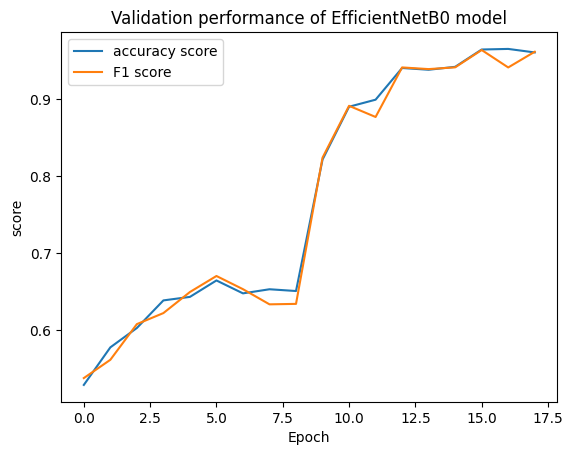

In [ ]:
plt.plot(accuracy_efnet, label='accuracy score')
plt.plot(f1_efnet, label='F1 score')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('score')
plt.title('Validation performance of EfficientNetB0 model')

Text(0.5, 1.0, 'train and validation loss of EfficientNetB0 model')

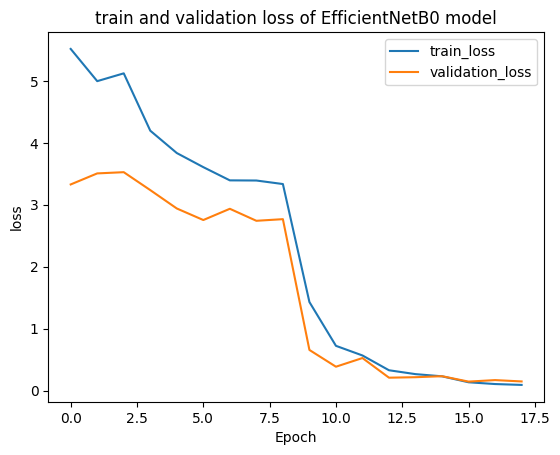

In [ ]:
plt.plot(train_loss_efnet, label='train_loss')
plt.plot(test_loss_efnet, label='validation_loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('loss')
plt.title('train and validation loss of EfficientNetB0 model')

# Final model evaluation

In [35]:
model = torch.load('EfficientNetB0_plus_96%_aug.pth').to(device)

In [28]:
loss_fn = nn.CrossEntropyLoss()
print(f'performance for data after transformation: {test(test_dataloader, model, loss_fn)}')
print(f'performance for data without transformation: {test(test_dataloader_no_transform, model, loss_fn)}')
print(f'performance for data without transformation at higher resolution: {test(test_dataloader_no_transform_large, model, loss_fn)}')

performance for data after transformation: (0.9771428571428571, 0.9543650793650793, 0.13046428561210632)
performance for data without transformation: (0.9824761904761905, 0.9827628968253967, 0.06552490592002869)
performance for data without transformation at higher resolution: (0.9432380952380952, 0.9450892857142856, 0.20161567628383636)


It is fun, but the model now requires lower resolution images to work. The normalize function is mandatory as well (data not shown)

In [16]:
labels = df[['class id', 'labels', 'scientific name']].groupby('class id').agg(lambda x: ', '.join(x.unique()))
labels.columns = ['labels', 'scientific name']

In [36]:
transform = v2.Compose([
                        v2.Resize(size=(112, 112)),
                        v2.ToDtype(torch.float32, scale=True),
                        v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) # those are mean and std from imagenet dataset. Those were used to train a model as stated in docs
                        ])

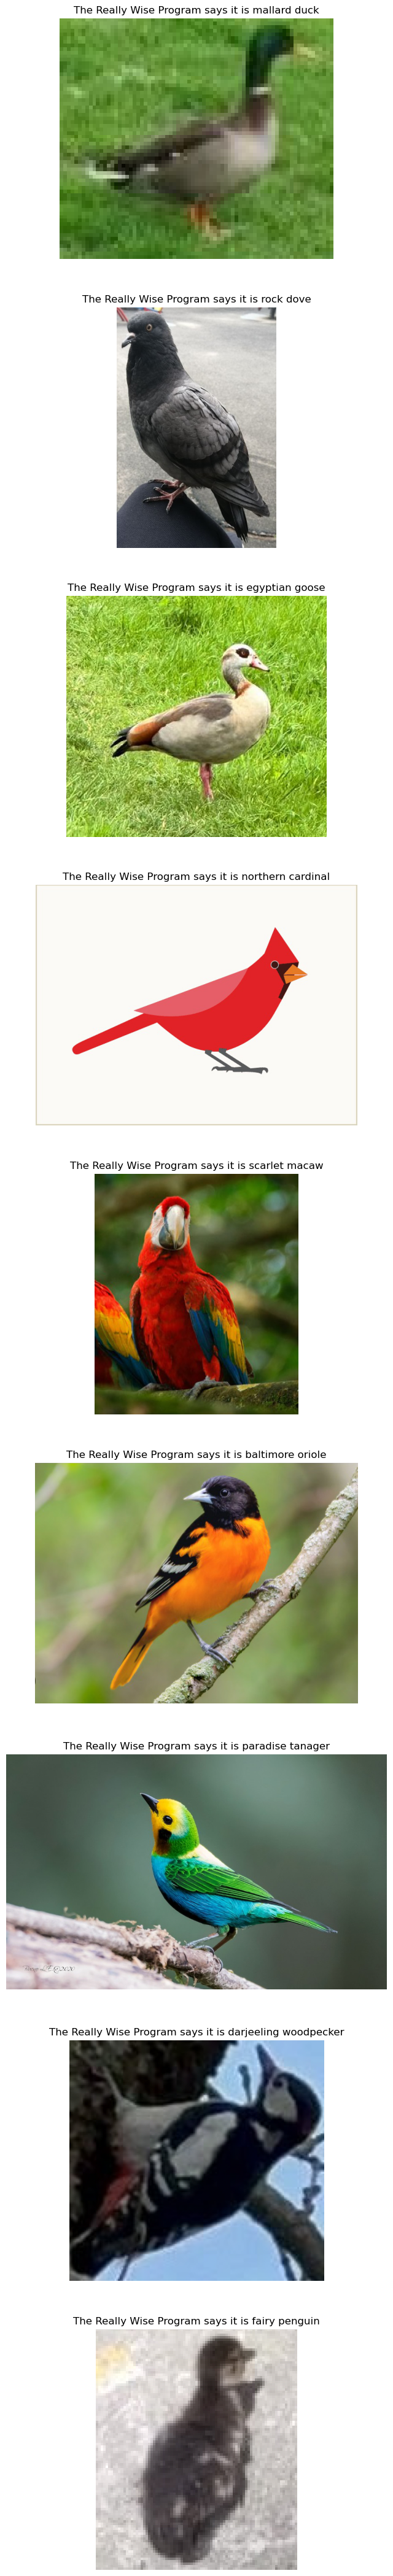

In [37]:

for dirname, _, filenames in os.walk('data/duck_test'):
    n_images = len(filenames)
    axes = plt.subplots(figsize=(8,n_images * 6), nrows=n_images)[1]

    for i, filename in enumerate(filenames):
        img_path = os.path.join(dirname, filename)
        image = Image.open(img_path)
        axes[i].imshow(image)
        axes[i].axis('off')
        image_tensor = transform(read_image(img_path))
        pred = model(image_tensor.unsqueeze(0).to(device))
        predicted = labels['labels'].iloc[pred.argmax().item()].lower()
        axes[i].set_title(f'The Really Wise Program says it is {predicted}')

For now the model correctly identifies birds which are presented in the dataset. With some limitations concerning juveniles.